# **POD란?**

* Pod는 쿠버네티스에서 사용되는 가장 작은 오브젝트이며 기본이 되는 단위이다.

* Pod는 하나 이상의 컨테이너가 포함되어 있으며 컨테이너의 그룹으로 Pod를 운영한다.

# **Pod 사용 이유**

* 컨테이너에 경우 단일 프로세스를 실행하도록 설계되어 있음. 한 컨테이너 안에 여러 프로세스를 사용하는 것을 지양해야 한다. 따라서 여러 프로세스를 여러 컨테이너로 나눠서 실행하는 것이 좋다.

* Pod는 컨테이너 그룹이기에 밀접하게 연관된 프로세스를 함께 실행하고 단일 컨테이너 안에서 모두 함께 실행되는 것처럼 동일한 환경을 제공할 수 있으면서도 이들을 격리된 상태로 유지할 수 있다.

* 동일한 Pod 안의 위치한 컨테이너들은 네트워크 어댑터와 파일 시스템을 공유할 수 있기 때문이다. 이를 통해 SideCar, Adapter 등의 패턴을 사용할 수 있다.

* Pod를 만들 때, 두 개의 컨테이너를 단일 파드로 넣을지, 두 개의 별도 파드에 넣을지를 결정해야 한다. 그러기 위해서 다음과 같은 질문이 도움이 된다.

- 컨테이너를 함께 실행해야 하는가, 혹은 서로 다른 호스트에서 실행할 수 있는가?
- 여러 컨테이너가 모여 하나의 구성 요소를 나타내는가, 혹은 개별적인 구성 요소인가?
- 컨테이너가 함께, 혹은 개별적으로 스케일링돼야 하는가?

### Pod의 생명주기



```
Pending	파드의 작성을 기다리고 있는 상태, 컨테이너 이미지의 다운로드 등에 시간이 걸리는 경우가 있습니다.
Running	파드가 가동 중인 상태
Succeeded	파드 안의 컨테이너가 정상적으로 종료된 상태
Failed	파드 안의 컨테이너 중 하나의 컨테이너가 실패하여 종료된 상태
Unknown	어떤 이유로 파드와 통신할 수 없는 상태
```



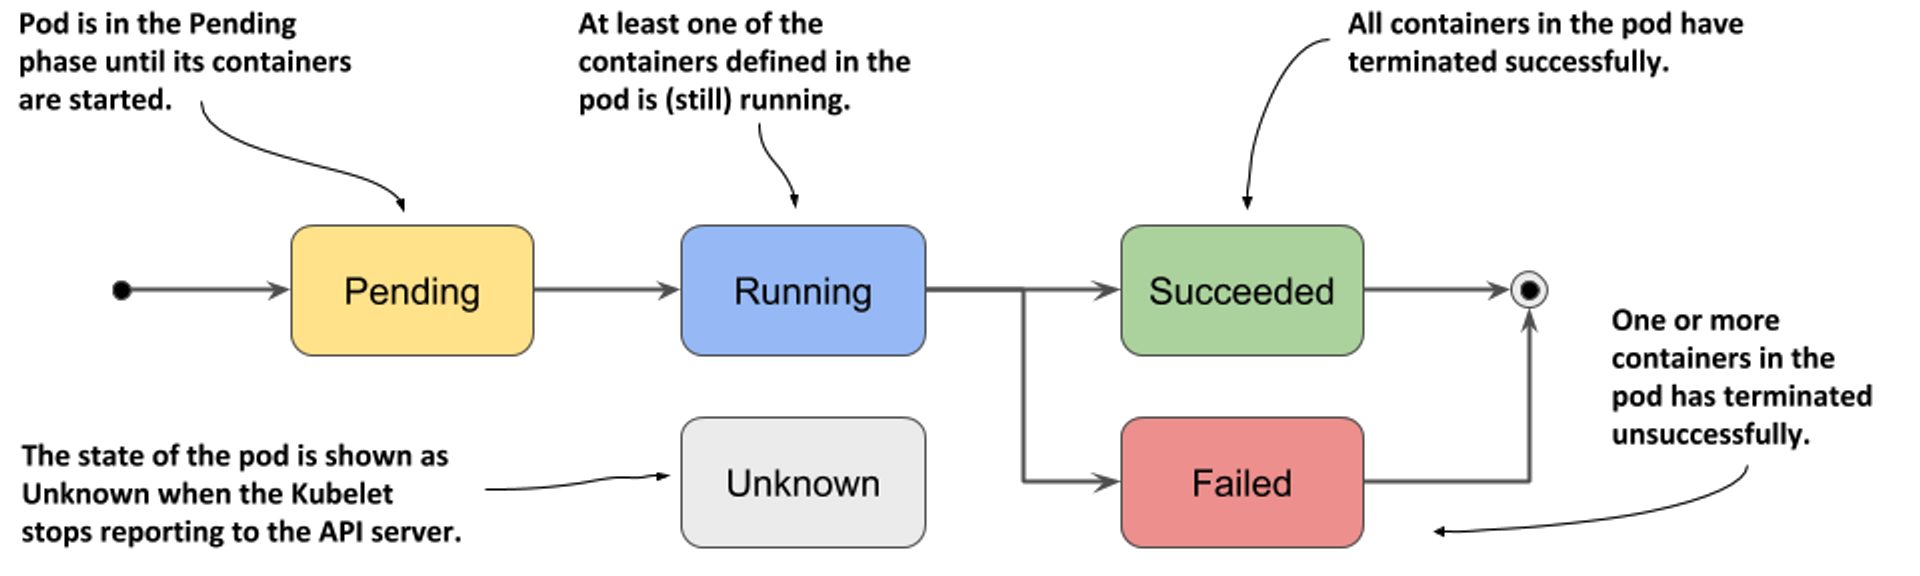

Pod는 Pending 단계에서 시작, 기본 컨테이너 중 적어도 하나 이상이 OK로 시작하게 되면 Running 단계를 통과,  파드의 컨테이너가 실패로 종료되었는지 여부에 따라 Succeeded 또는 Failed 단계로 이동.

Pod의 세부 내용을 통해서도 생명주기를 파악할 수 있다.

```java
hello-world-1  ➤ kubectl describe pods go-hello-world-575c999b7b-ccgc8 
Name:         go-hello-world-575c999b7b-ccgc8
Namespace:    default
Priority:     0
Node:         gke-cluster-1-node-5d0554bf-2egv/192.168.0.20
Start Time:   Sun, 14 Aug 2022 13:21:53 +0900
Labels:       app=go-hello-world
              pod-template-hash=575c999b7b
              skaffold.dev/run-id=015af20c-4913-4fbc-9947-705e251c1b4b
Annotations:  <none>
Status:       Running
...생략...
Conditions:
  Type              Status
  Initialized       True 
  Ready             True 
  ContainersReady   True 
  PodScheduled      True 
...생략...
```

Status를 통해 running하고 있다는 것을 볼 수 있다.

Conditions를 통해 Pod의 현재상태 정보를 알 수 있다.

```bash
Initialized	모든 초기화 컨테이너가 성공적으로 시작 완료됨
Ready	Pod는 요청들을 실행할 수 있고, 연결된 모든 서비스의 로드밸런싱 풀에 추가되어야 함
ContainerReady	Pod안에 있는 모든 컨테이너들이 준비가 완료됨
PodScheduled	Pod가 하나의 노드로 스케줄을 완료함
Unschedulable	스케줄러가 자원의 부족이나 다른 제약 등으로 지금 당장 파드를 스케줄 할 수 없음
```

Status는 Type의 상태를 나타내는 True(상태 활성화), False(상태 비활성화), Unknown(상태 알 수 없음) 값을 출력.

# **Pod의 Probe**

* 쿠버네티스 클러스터 상에는 많은 Pod가 가동됨. 이것들이 정상적으로 움직이고 있는지 아닌지를 체크해서 문제가 있으면 재빨리 복구해야 함.

* 쿠버네티스에서는 컨테이너 애플리케이션이 올바르게 움직이고 있는지 아닌지를 항상 감시하여 문제가 있으면 파드를 자동으로 재시작하는 장치가 있다. 이를 `Probe`라고 한다.

**StartupProbe**

컨테이너 내의 애플리케이션이 시작되었는지를 나타낸다. 스타트업 프로브(startup probe)가 주어진 경우, 성공할 때 까지 다른 나머지 프로브는 활성화 되지 않는다. 만약 스타트업 프로브가 실패하면, kubelet이 컨테이너를 죽이고, 컨테이너는 **[재시작 정책](https://kubernetes.io/ko/docs/concepts/workloads/pods/pod-lifecycle/#%EC%9E%AC%EC%8B%9C%EC%9E%91-%EC%A0%95%EC%B1%85)**에 따라 처리된다. 컨테이너에 스타트업 프로브가 없는 경우, 기본 상태는 Success 이다.

****ReadinessProbe****

ReadinessProbe는 애플리케이션이 시작할 준비가 되었는지 체크하기 위해 사용된다. ****Pod의 생명주기중 Pending 상태에서의 동작, 서비스 요청에 응답가능한지 확인한다. Service와 연결된 Pod를 확인하여 Readiness Probe에 대해 응답이 없거나 실해 응답을 보낸다면 해당 Pod를 사용불가능한 상태라고 판단하여 서비스 목록에 제외한다.

**굵은 텍스트**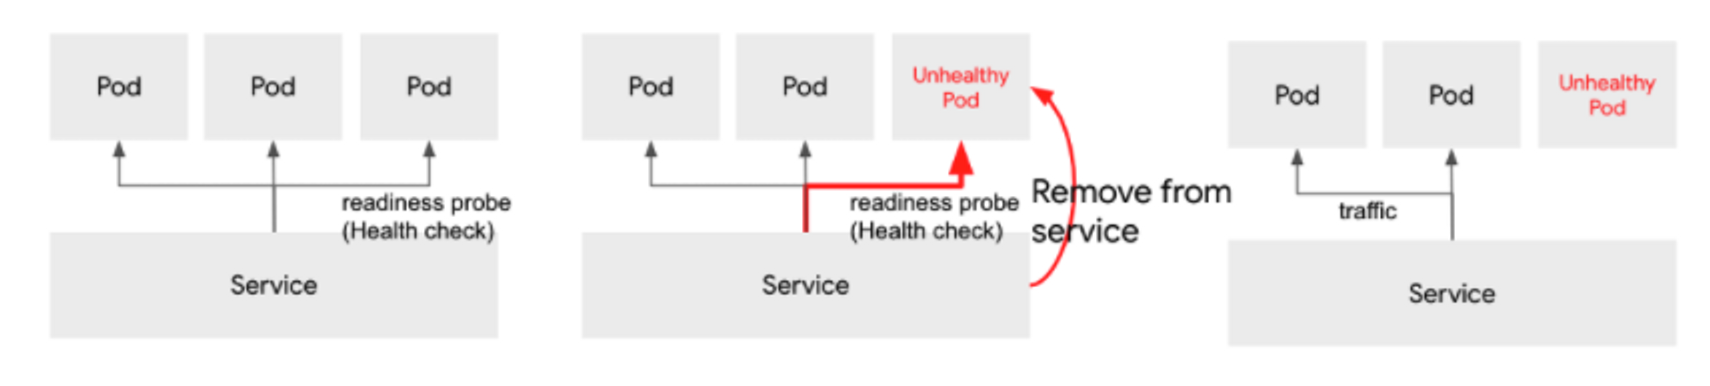

**LivenessProbe**

LivenessProbe는 애플리케이션이 응답가능한지 확인하는 부분에 사용된다**.** Pod의 생명주기중 Running 상태에서의 동작 즉, 컨테이너가 정상 실행중인지 확인한다. 컨테이너의 상태를 주기적으로 체크하여, 응답이 없다면 컨테이너를 자동으로 재시작한다.

LivenessProbe를 설정하지 않으면 기본 상태값은 Success다.

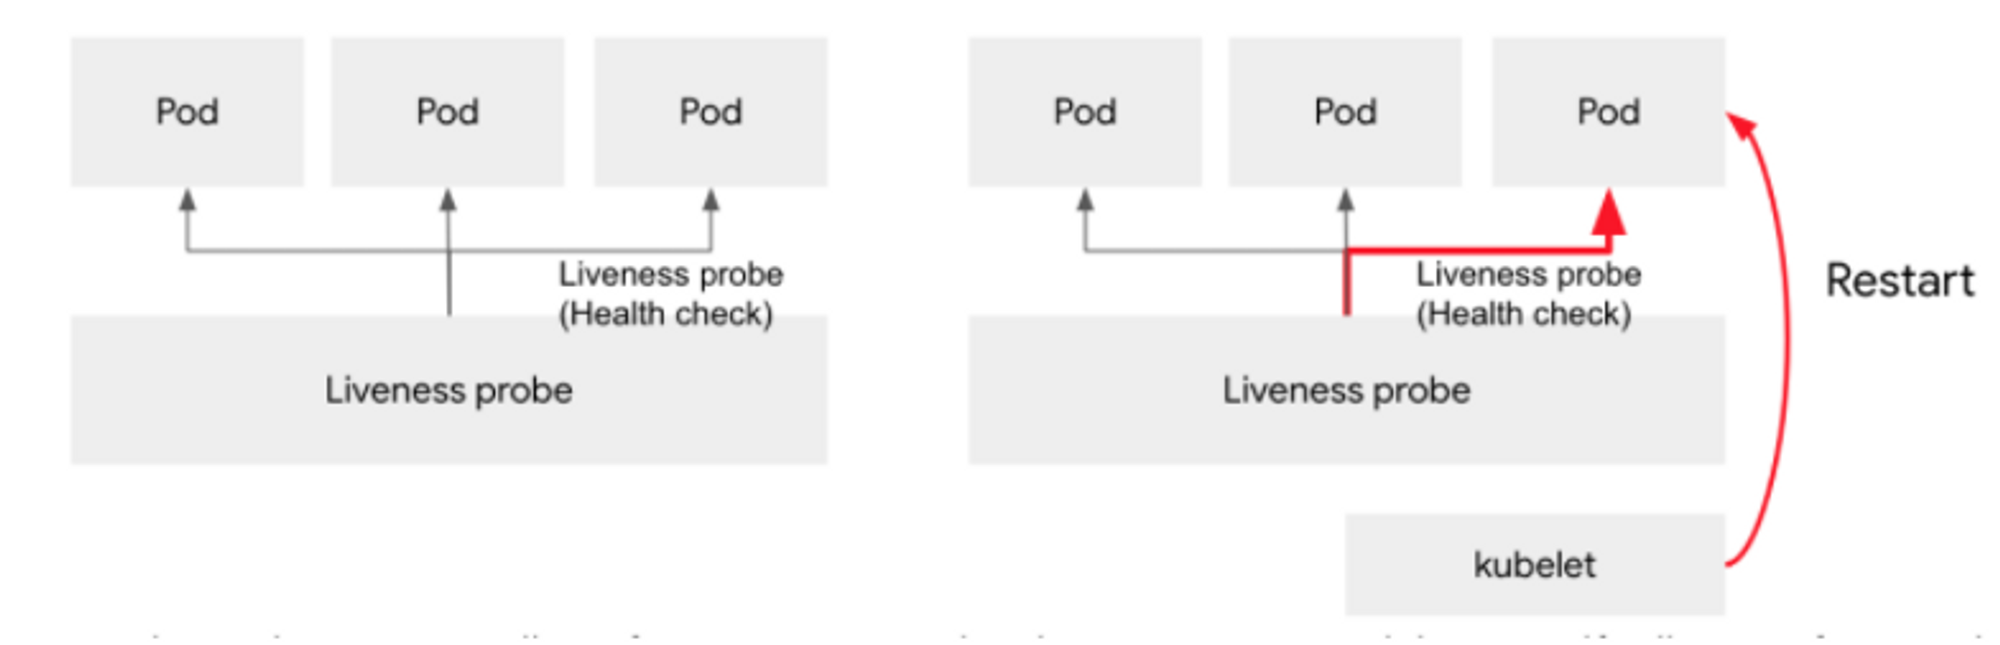

# **Pod Probe의 3가지 방식**

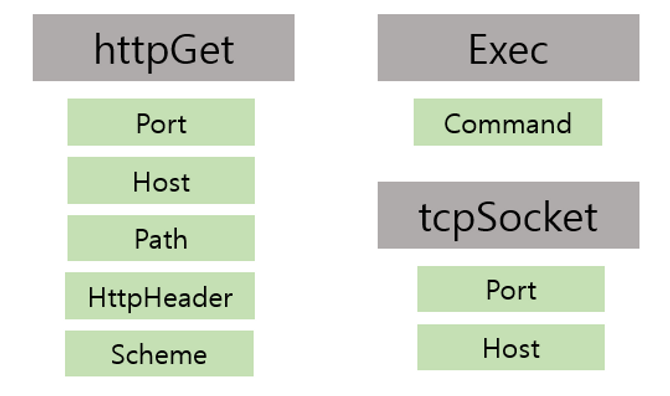

- Command probe
    - 컨테이너의 상태 체크를 쉘 명령으로 수행한 결과에 따라 정상여부를 체크
        - 결과값이 0이면 성공, 0이 아니면 실패로 간주
    - "exec"으로 정의하고 "command : " 아래에 실행하고자 하는 쉘 명령을 기입
- Http probe
    - 가장 많이 사용하는 Probe 방식으로 Http GET을 이용하여 컨테이너 상태를 체크
    - 지정된 URL로 HTTP GET 요청을 보내, 리턴되는 HTTP 응답코드가 200~3xx이라면 정상으로 판단
- TCP probe
    - 지정된 포트에 TCP 연결을 시도하여, 연결이 성공되면 컨테이너가 정상인것으로 판단

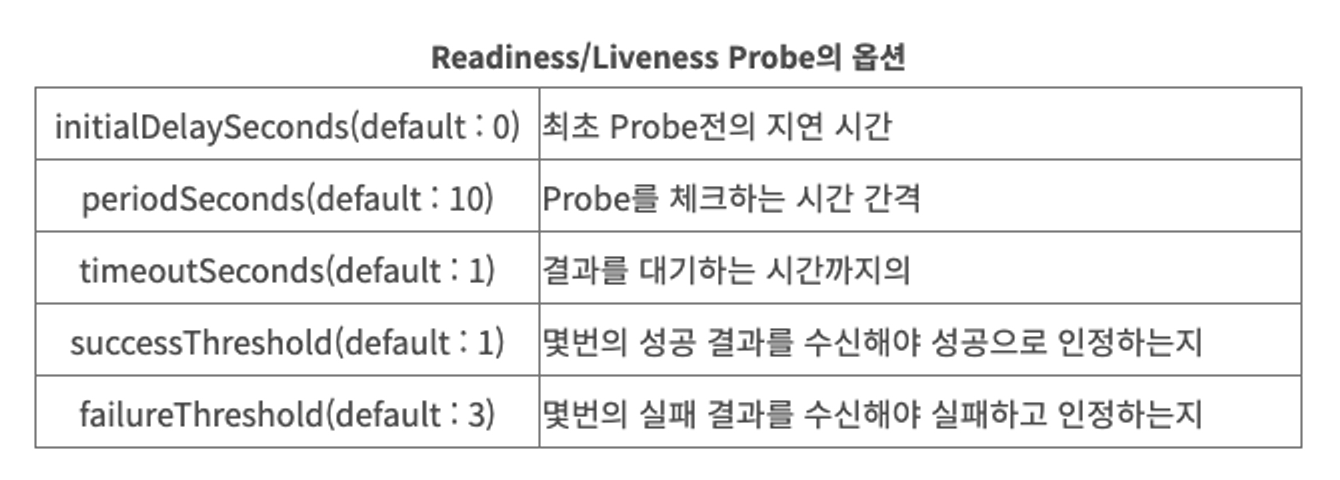

**언제 스타트업 프로브(startup probe)를 사용해야 하는가?**

- 컨테이너가 보통 `초기 지연 시간 + 실패 임계 값 * 대기 초(initialDelaySeconds + failureThreshold * periodSeconds)` 이후에 기동된다면, 스타트업 프로브가 활성화 프로브와 같은 엔드포인트를 체크하도록 명시해야 함.

- periodSeconds의 기본 값은 30초 이다. 이 때 컨테이너가 활성화 프로브의 기본 값 변경 없이 기동되도록 하려면 failureThreshold를 충분히 높게 설정해주어야 함. 그래야 데드락(deadlock)을 방지하는데 도움이 됨.

**언제 활성 프로브(liveness probe)를 사용해야 하는가?**

- 만약 컨테이너 속 프로세스가 어떠한 이슈에 직면하거나 건강하지 못한 상태(unhealthy)가 되는 등 프로세스 자체의 문제로 중단될 수 있더라도, 활성 프로브가 반드시 필요한 것은 아님. 이러한 경우에는 kubelet이 파드의 재시작 정책(restart policy)에 따라서 올바른 대처를 자동적으로 수행.

- 프로브가 실패한 후 컨테이너가 종료되거나 재시작 되기를 원한다면, 활성 프로브를 지정하고, 재시작 정책을 항상(Always) 또는 실패 시(OnFailure)로 지정.

**언제 준비성 프로브(readiness probe)를 사용해야 하는가?**

- 프로브가 성공한 경우에만 파드에 트래픽 전송을 시작하려고 한다면, 준비성 프로브를 지정.  준비성 프로브가 활성 프로브와 유사해 보일 수도 있지만, 스팩에 준비성 프로브가 존재한다는 것은 파드가 트래픽을 받지 않는 상태에서 시작되고 프로브가 성공하기 시작한 이후에만 트래픽을 받는다는 것. 컨테이너가 대량의 데이터, 설정 파일들, 또는 시동 중 마이그레이션을 처리해야 한다면, 준비성 프로브를 지정하기를 권장

- 컨테이너가 유지 관리를 위해서 자체 중단되게 하려면, 준비성 프로브를 지정하길 권장. 준비성 프로브는 활성 프로브와는 다르게 준비성에 특정된 엔드포인트를 확인.

- 파드가 삭제될 때 단지 요청들이 흘려 보낼(drain) 목적으로, 준비성 프로브가 필요하지 않다는 점을 유념해야함. 삭제 시에, 파드는 프로브의 존재 여부와 무관하게 자동으로 스스로를 준비되지 않은 상태(unready)로 변경한다. 파드는 파드 내의 모든 컨테이너들이 중지될 때 까지 준비되지 않은 상태로 남아있음음.